In [4]:
from keras.preprocessing.image import load_img, img_to_array

In [5]:
target_image_path  = r'Y:\Documents\StyleNetwork\City_1.jpg'
style_reference_image_path = r'Y:\Documents\StyleNetwork\Graphic_1.jpg'

In [6]:
width, height = load_img(target_image_path).size
width, height

(1500, 969)

In [7]:
img_height  = 400
img_width = int(width * img_height / height)
img_width

619

In [8]:
import  numpy  as  np
from keras.applications import xception

In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = xception.preprocess_input(img)
    return img

In [10]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

In [12]:
# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.                                                
model = xception.Xception(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Xception Model loaded.')

83689472/83683744 [==============================] - 23s 0us/step
Xception Model loaded.


In [20]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [21]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [22]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [24]:
content_layer = 'block14_sepconv1_act'

style_layers = ['block1_conv1_act',
                'block1_conv2_act',
                'add_1',
                'add_2',
                'add_3',
                'add_4',
                'add_5',
                'add_6',
                'add_7',
                'add_8',
                'add_9',
                'add_10',
                'add_11',
                'add_12']

In [25]:
for layer in model.layers:
    #if 'Relu' in str(layer.output):
    print(layer.name, layer.output, '\n')

input_2 Tensor("concat_1:0", shape=(3, 400, 619, 3), dtype=float32) 

block1_conv1 Tensor("block1_conv1/convolution:0", shape=(3, 199, 309, 32), dtype=float32) 

block1_conv1_bn Tensor("block1_conv1_bn/cond/Merge:0", shape=(3, 199, 309, 32), dtype=float32) 

block1_conv1_act Tensor("block1_conv1_act/Relu:0", shape=(3, 199, 309, 32), dtype=float32) 

block1_conv2 Tensor("block1_conv2/convolution:0", shape=(3, 197, 307, 64), dtype=float32) 

block1_conv2_bn Tensor("block1_conv2_bn/cond/Merge:0", shape=(3, 197, 307, 64), dtype=float32) 

block1_conv2_act Tensor("block1_conv2_act/Relu:0", shape=(3, 197, 307, 64), dtype=float32) 

block2_sepconv1 Tensor("block2_sepconv1/separable_conv2d:0", shape=(3, 197, 307, 128), dtype=float32) 

block2_sepconv1_bn Tensor("block2_sepconv1_bn/cond/Merge:0", shape=(3, 197, 307, 128), dtype=float32) 

block2_sepconv2_act Tensor("block2_sepconv2_act/Relu:0", shape=(3, 197, 307, 128), dtype=float32) 

block2_sepconv2 Tensor("block2_sepconv2/separable_conv2d:0

In [29]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block14_sepconv2_bn'

style_layers = ['block1_conv1_act',
                'block1_conv2_act',
                'add_1',
                'add_2',
                'add_3',
                'add_4',
                'add_5',
                'add_6',
                'add_7',
                'add_8',
                'add_9',
                'add_10',
                'add_11',
                'add_12']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [27]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [30]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 40

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 8.112322
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 175s
Start of iteration 1


/Users/yuristickney/anaconda2/envs/tensorflow36/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 8.063786
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 176s
Start of iteration 2


KeyboardInterrupt: 

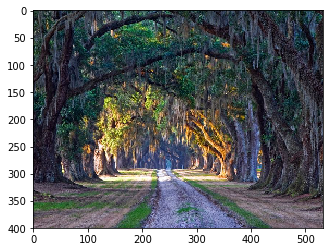

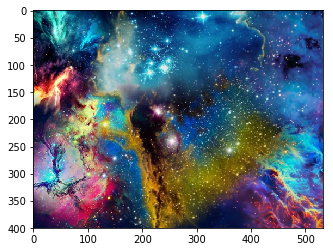

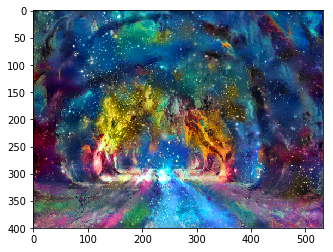

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()